In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd 
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

# Define the stock and time period
ticker = "VOO"
period = "1y"  # 1 year of data

# Pull data
df = yf.download(ticker, period=period)

# Calculate Moving Averages (75-day)
df['EMA_75'] = df['Close'].ewm(span=100, adjust=False).mean()

# Calculate Price Returns (Daily Percentage Change)
df['Price_Return'] = df['Close'].pct_change() * 100

df = df[['Close', 'Volume', 'EMA_75', 'Price_Return']]

# Drop NaN values (caused by moving average calculations)
df.dropna(inplace=True)
df.reset_index(inplace=True)

print(df.shape)
print(df)

# Define Labeling Function
def label(pr):
    # Label as 1 (Buy) if Price_Return > 1%
    # Label as -1 (Sell) if Price_Return < -1%
    # Otherwise, 0 (Hold)
    if pr > 1:  # This should work fine
        return 2
    elif pr < -1:
        return 0
    else:
        return 1

print(df.columns)
# Apply the label function correctly to each row
labels = []
for index, row in df.iterrows():
    # Extract the value as a single float
    pr = row['Price_Return']['']
    temp = label(pr)
    labels.append(temp)

df['Label'] = labels

print(df.head(3))  # Check the output

df = df[['Close', 'Volume', 'EMA_75', 'Price_Return', 'Label']]

# ---------------------- Data Preparation ----------------------

# Standardize data
X = df[['Close', 'Volume', 'EMA_75', 'Price_Return']].to_numpy()
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = (X - X_mean) / X_std  # Standardization

# Target variable
y = df['Label'].to_numpy()

# ----------------- Splitting Data 80/20----------------

# Apply SMOTE to oversample the minority class
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


(250, 5)
Price        Date       Close   Volume      EMA_75 Price_Return
Ticker                    VOO      VOO                         
0      2024-05-15  480.460144  4399500  474.792178     1.218189
1      2024-05-16  479.542450  3347400  474.886243    -0.191003
2      2024-05-17  480.252960  3274000  474.992514     0.148164
3      2024-05-20  480.726593  2599600  475.106060     0.098622
4      2024-05-21  482.019287  2453600  475.242956     0.268904
..            ...         ...      ...         ...          ...
245    2025-05-08  519.340027  5088200  518.940592     0.666796
246    2025-05-09  518.650024  4739500  518.934838    -0.132861
247    2025-05-12  535.919983  7793600  519.271177     3.329790
248    2025-05-13  539.440002  7356800  519.670560     0.656818
249    2025-05-14  539.330017  4405285  520.059856    -0.020389

[250 rows x 5 columns]
MultiIndex([(        'Date',    ''),
            (       'Close', 'VOO'),
            (      'Volume', 'VOO'),
            (      'EMA_

In [3]:
# ---------------------- MLP Model ----------------------

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # First fully connected layer
        self.fc2 = nn.Linear(hidden_size, output_size)  # Second fully connected layer

    def forward(self, x):
        x = F.sigmoid(self.fc1(x))  # Apply activation function on first layer
        x = F.log_softmax(self.fc2(x), dim=1)  # Apply softmax on the output layer
        return x

# Initialize the model
model = MLP(input_size=X_train.shape[1], hidden_size=100, output_size=3)

# Loss function and optimizer
optimizer = optim.SGD(model.parameters(), lr=0.1)
criteria = nn.NLLLoss()

# Training the model
epochs = 10
for epoch in range(epochs):
    running_loss = 0.0
    for i in range(len(X_train)):
        sample = torch.tensor(X_train[i], dtype=torch.float32).unsqueeze(0)
        label = torch.tensor(y_train[i], dtype=torch.long).unsqueeze(0)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(sample)

        # Compute the loss
        loss = criteria(outputs, label)

        # Backward pass
        loss.backward()

        # Optimize the weights
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}: Loss: {running_loss / len(X_train):.2f}")


Epoch 1/10: Loss: 0.61
Epoch 2/10: Loss: 0.21
Epoch 3/10: Loss: 0.15
Epoch 4/10: Loss: 0.13
Epoch 5/10: Loss: 0.11
Epoch 6/10: Loss: 0.10
Epoch 7/10: Loss: 0.10
Epoch 8/10: Loss: 0.09
Epoch 9/10: Loss: 0.08
Epoch 10/10: Loss: 0.08


True Label: 0, Predicted Label: 0
Test Accuracy: 99.12%


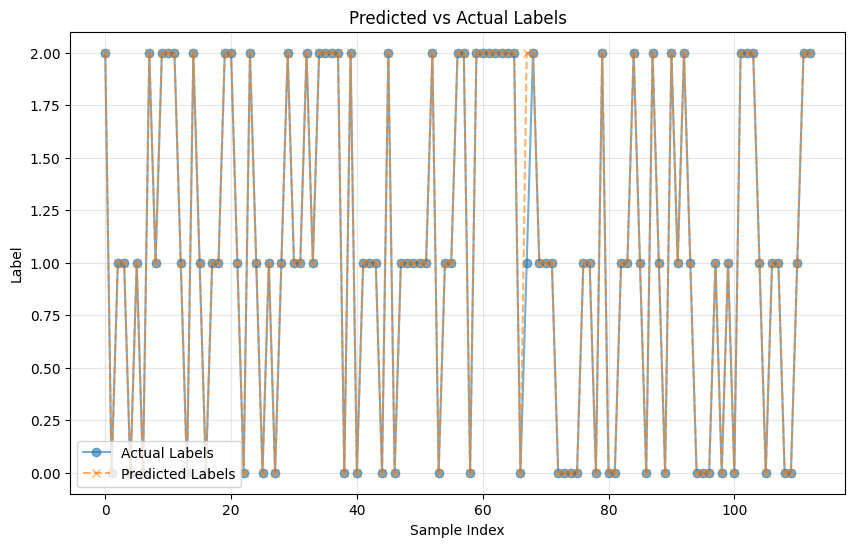

In [4]:
# ---------------------- Model Testing ----------------------

# Get one image from the test dataset and visualize
from random import randint
idx = randint(0, len(X_test) - 1)
sample = torch.tensor(X_test[idx], dtype=torch.float32)
true_label = y_test[idx]

# Inference phase
model.eval()  # Set model to evaluation mode
with torch.no_grad():  # Disable gradient computations temporarily
    output = model(sample.unsqueeze(0))  # Add batch dimension
    predicted_label = output.argmax(dim=1).item()  # Get predicted label with max probability

print(f"True Label: {true_label}, Predicted Label: {predicted_label}")

# For testing the overall accuracy
correct = 0
total = 0
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for i in range(len(X_test)):
        sample = torch.tensor(X_test[i], dtype=torch.float32)
        label = torch.tensor(y_test[i], dtype=torch.long)

        # Predict
        outputs = model(sample.unsqueeze(0))
        _, predicted = torch.max(outputs, 1)

        total += 1
        correct += (predicted == label).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

# ---------------------- Plotting Results ----------------------

# For plotting the predictions vs. actual
pred_labels = []
for i in range(len(X_test)):
    sample = torch.tensor(X_test[i], dtype=torch.float32)
    output = model(sample.unsqueeze(0))
    pred_labels.append(output.argmax(dim=1).item())

plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, label='Actual Labels', marker='o', linestyle='-', alpha=0.6)
plt.plot(range(len(pred_labels)), pred_labels, label='Predicted Labels', marker='x', linestyle='--', alpha=0.6)
plt.xlabel('Sample Index')
plt.ylabel('Label')
plt.title('Predicted vs Actual Labels')
plt.grid(alpha=0.3)
plt.legend()
plt.show()

Epoch 1/50 - Train Loss: 0.0767, Test Loss: 0.0237, Train Acc: 0.9643, Test Acc: 0.9912
Epoch 2/50 - Train Loss: 0.0735, Test Loss: 0.0220, Train Acc: 0.9665, Test Acc: 0.9912
Epoch 3/50 - Train Loss: 0.0708, Test Loss: 0.0205, Train Acc: 0.9710, Test Acc: 0.9912
Epoch 4/50 - Train Loss: 0.0685, Test Loss: 0.0193, Train Acc: 0.9710, Test Acc: 0.9912
Epoch 5/50 - Train Loss: 0.0665, Test Loss: 0.0182, Train Acc: 0.9710, Test Acc: 1.0000
Epoch 6/50 - Train Loss: 0.0649, Test Loss: 0.0173, Train Acc: 0.9754, Test Acc: 1.0000
Epoch 7/50 - Train Loss: 0.0636, Test Loss: 0.0165, Train Acc: 0.9754, Test Acc: 1.0000
Epoch 8/50 - Train Loss: 0.0624, Test Loss: 0.0158, Train Acc: 0.9732, Test Acc: 1.0000
Epoch 9/50 - Train Loss: 0.0613, Test Loss: 0.0152, Train Acc: 0.9732, Test Acc: 1.0000
Epoch 10/50 - Train Loss: 0.0604, Test Loss: 0.0146, Train Acc: 0.9732, Test Acc: 1.0000
Epoch 11/50 - Train Loss: 0.0595, Test Loss: 0.0141, Train Acc: 0.9732, Test Acc: 1.0000
Epoch 12/50 - Train Loss: 0.05

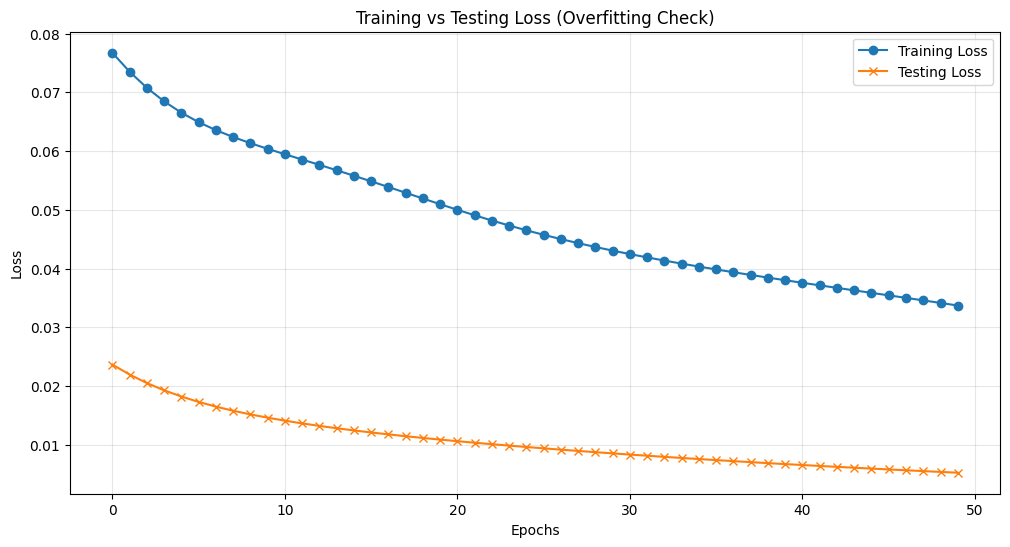

In [5]:
# Training with overfitting monitoring
epochs = 50
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    for i in range(len(X_train)):
        sample = torch.tensor(X_train[i], dtype=torch.float32).unsqueeze(0)
        label = torch.tensor([y_train[i]], dtype=torch.long)

        optimizer.zero_grad()
        outputs = model(sample)
        loss = criteria(outputs, label)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        correct_train += (outputs.argmax(dim=1) == label).sum().item()

    train_loss = running_loss / len(X_train)
    train_accuracy = correct_train / len(X_train)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Testing phase
    model.eval()
    running_loss = 0.0
    correct_test = 0
    with torch.no_grad():
        for i in range(len(X_test)):
            sample = torch.tensor(X_test[i], dtype=torch.float32).unsqueeze(0)
            label = torch.tensor([y_test[i]], dtype=torch.long)
            outputs = model(sample)
            loss = criteria(outputs, label)
            running_loss += loss.item()
            correct_test += (outputs.argmax(dim=1) == label).sum().item()

    test_loss = running_loss / len(X_test)
    test_accuracy = correct_test / len(X_test)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Acc: {train_accuracy:.4f}, Test Acc: {test_accuracy:.4f}")

# ---------------------- Plotting ----------------------

# Plotting Loss
plt.figure(figsize=(12, 6))
plt.plot(range(epochs), train_losses, label='Training Loss', marker='o')
plt.plot(range(epochs), test_losses, label='Testing Loss', marker='x')
plt.title('Training vs Testing Loss (Overfitting Check)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(alpha=0.3)
plt.show()
